In [ ]:

"""PatchSim: A system for doing metapopulation SEIR* models."""
import time
import logging
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

drive.mount("/content/drive")

logger = logging.getLogger(__name__)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_config(config_file):
    """Read configuration.

    Configuration files contain one key=value pair per line.
    The following is an example of the contents of a config file::

        PatchFile=test_pop.txt
        NetworkFile=test_net.txt
        NetworkType=Static

        ExposureRate=0.65
        InfectionRate=0.67
        RecoveryRate=0.4
        ScalingFactor=1

        SeedFile=test_seed.txt
        VaxFile=test_vax.txt
        VaxDelay=4
        VaxEfficacy=0.5

        StartDate=1
        Duration=30

        LoadState=False
        SaveState=True
        SaveFile=checkpoint1.npy

        OutputFile=test1.out
        OutputFormat=Whole
        LogFile=test1.log

    Parameters
    ----------
    config_file : str
        Path to the configuration file.

    Returns
    -------
    dict (str -> str)
        The configuration key value pairs.
    """
    config_df = pd.read_csv(config_file, delimiter="=", names=["key", "val"])
    configs = dict(zip(config_df.key, config_df.val))
    configs.setdefault("Model", "Mobility")
    return configs

In [ ]:
def load_patch(configs):
    """Load the patch file.

    A patch file contains the population size of a patch.
    The file has two space separated columns.
    Following is an example of a patch file::

        A 10000
        B 10000
        C 10000

    Parameters
    ----------
    configs : dict
        The configuration dictionary.
        Must contain the "PatchFile" pointing to location of patch file.

    Returns
    -------
    DataFrame (names=(id, pops), dtypes=(str, float))
        A dataframe containing populations of patches.
    """
    if configs["Model"] == 'Ross-Macdonald':
      patch_df = pd.read_csv(
          configs["PatchFile"],
          names=["id", "pops", "vector_pops"],
          delimiter=" ",
          dtype={"id": str, "pops": float, "vector_pops": float},
      )
    else:
      patch_df = pd.read_csv(
          configs["PatchFile"],
          names=["id", "pops"],
          delimiter=" ",
          dtype={"id": str, "pops": float},
        )
    patch_df.sort_values("id", inplace=True)

    logger.info("Loaded patch attributes")
    return patch_df

In [ ]:
def load_param_file(configs):
    """Load the parameter file.

    A parameter file contains one row per patch.
    Each row must have two or more columns.
    Following is an example of a paremter file::

        B 0 0 0.54 0.54 0.54 0.54 0 0 0 0
        A 0.72

    Parameters
    ----------
    configs : dict
        The configuration dictionary.
        Must contain the "ParamFile" pointing to location of parameter file.
    patch_df : DataFrame
        A dataframe containing populations of patches.

    Returns
    -------
    DataFrame
         A dataframe with one column per patch.
         The column names are IDs of the patches.
         Each column contains the "beta" value of the patch over time.
    """
    param_df = pd.read_csv(
        configs["ParamFile"], delimiter=" ", dtype={0: str}, header=None
    )
    param_df = param_df.set_index(0)
    param_df = param_df.fillna(method="ffill", axis=1)
    param_df = param_df.T

    return param_df

In [ ]:
def load_params(configs, patch_df):
    """Load the simulation parameters.

    Parameters
    ----------
    configs : dict
        The configuration key value pairs.
    patch_df : DataFrame
        A dataframe containing populations of patches.

    Returns
    -------
    dict (str -> float or ndarray)
        A dictionary of model parameters.
        The "beta" parameter is a ndarray
        with shape=(NumPatches x NumTimesteps)
        and dtype=float.
    """
    params = {}
    params["T"] = int(configs["Duration"])

    beta = float(configs.get("ExposureRate", 0.0))
    params["beta"] = np.full((len(patch_df), params["T"]), beta)
    params["alpha"] = float(configs.get("InfectionRate", 0.0))
    params["gamma"] = float(configs.get("RecoveryRate", 0.0))
    params["a"] = float(configs.get("MosquitoBitesPerDay", 0.0))
    params["b"] = float(configs.get(
        "MosquitoToHumanTransmissionEfficiency", 0.0))
    params["c"] = float(configs.get(
        "HumanToMosquitoTransmissionEfficiency", 0.0))
    params["IP"] = float(configs.get(
        "IncubationPeriodForVector", 0.0))
    params["g"] = float(configs.get("RateOfMosquitoDeath", 0.0))
    betaRM_human = float(configs.get("betaRM_human", 0.0))
    if betaRM_human == None or betaRM_human == 0:
      betaRM_human = float(params["a"]*params["b"]*np.exp(-(params["g"]*params["IP"])))
    betaRM_vector = float(configs.get("betaRM_human", 0.0))
    if betaRM_vector == None or betaRM_vector == 0:
      betaRM_vector = float(params["a"]*params["c"])
    params["betaRM_human"] = np.full((len(patch_df), params["T"]), betaRM_human)
    params["betaRM_vector"] = np.full((len(patch_df), params["T"]), betaRM_vector)

    logger.info(
        "Parameter: alpha=%e, beta=%e, gamma=%e, a=%e, b=%e, c=%e, IP=%e, g=%e", params["alpha"], beta, params["gamma"], params["a"], params["b"], params["c"], params["g"]
    )

    if "ParamFile" in configs:
        param_df = load_param_file(configs)
        for i, id_ in enumerate(patch_df["id"]):
            if id_ in param_df.columns:
                xs = param_df[id_]
                params["beta"][i, 0 : len(xs)] = xs
        logger.info("Loaded disease parameters from ParamFile")
    else:
        logger.info("No ParamFile loaded")

    ### Optional parameters
    params["scaling"] = float(configs.get("ScalingFactor", 1.0))
    params["vaxeff"] = float(configs.get("VaxEfficacy", 1.0))
    params["delta"] = float(configs.get("WaningRate", 0.0))
    params["vaxdelta"] = float(configs.get("VaxWaningRate", 0.0))
    params["kappa"] = float(configs.get("AsymptomaticReduction", 1.0))
    params["symprob"] = float(configs.get("SymptomaticProbability", 1.0))
    params["epsilon"] = float(configs.get("PresymptomaticReduction", 1.0))

    #     if params["delta"]:
    #         logger.info("Found WaningRate. Running SEIRS model.")

    return params

In [ ]:
def load_seed(configs, params, patch_df):
    """Load the disease seeding schedule file.

    A seed file contains the disease seeding schedule.
    Following is an example of the contents of a seed file::

        0 A 20
        0 B 20
        1 C 20
        2 C 30

    Parameters
    ----------
    configs : dict
        The configuration dictionary.
    params: dict (str -> float or ndarray)
        A dictionary of model parameters.
    patch_df : DataFrame
        A dataframe containing populations of patches.

    Returns
    -------
    ndarray shape=(NumTimsteps x NumPatches)
        A seeding schedule matrix
    """
    if "SeedFile" not in configs:
        logger.info("Continuing without seeding")
        return np.zeros((params["T"], len(patch_df)))

    seed_df = pd.read_csv(
        configs["SeedFile"],
        delimiter=" ",
        names=["Day", "Id", "Count"],
        dtype={"Id": str},
    )

    seed_mat = np.zeros((params["T"], len(patch_df)))
    seed_df = seed_df[
        seed_df.Day < params["T"]
    ]  ### Skipping seeds after end of simulation
    patch_idx = {id_: i for i, id_ in enumerate(patch_df["id"])}
    print(patch_idx)
    for day, id_, count in seed_df.itertuples(index=False, name=None):
        idx = patch_idx[id_]
        seed_mat[day, idx] = count

    logger.info("Loaded seeding schedule")
    return seed_mat

In [ ]:
def load_vax(configs, params, patch_df):
    """Load the vaccination schedule file.

    A vax file contains the vaccination schedule.
    Following is an example of the contents of the vax file::

        0 A 10
        2 B 10
        5 C 10

    Parameters
    ----------
    configs : dict
        The configuration dictionary.
    params: dict (str -> float or ndarray)
        A dictionary of model parameters.
    patch_df : DataFrame
        A dataframe containing populations of patches.

    Returns
    -------
    ndarray shape=(NumTimsteps x NumPatches)
        A vaccination schedule matrix (NumTimsteps x NumPatches)
    """
    vax_mat = np.zeros((params["T"], len(patch_df)), dtype=int)

    if "VaxFile" not in configs:
        return vax_mat

    vax_df = pd.read_csv(
        configs["VaxFile"],
        delimiter=" ",
        names=["Day", "Id", "Count"],
        dtype={"Id": str, "Count": int},
    )
    vax_delay = int(configs.get("VaxDelay", 0))

    vax_df = vax_df[
        vax_df.Day < params["T"] - vax_delay
    ]  ### Skipping vaxs which get applied after end of simulation
    patch_idx = {id_: i for i, id_ in enumerate(patch_df["id"])}
    for day, id_, count in vax_df.itertuples(index=False, name=None):
        idx = patch_idx[id_]
        day = day + vax_delay
        vax_mat[day, idx] = count

    return vax_mat

NORMALIZAR LOS RATES DE QUARANTINE

In [ ]:
def apply_quarantine(travel_matrix, quarantine_rate_df, quarantine_rate_column):
  travel_matrix = travel_matrix.copy()
  quarantine_rates_list = [rate for rate in quarantine_rate_df[quarantine_rate_column]]
  travel_matrix['flow_with_quarantine'] = travel_matrix['flow']
  time_indexes = travel_matrix['theta_index'].unique()
  self_travel = travel_matrix.loc[travel_matrix["src_Id"] == travel_matrix["dest_Id"]]
  for t in time_indexes:
    travel_matrix['flow_with_quarantine'] = np.where(travel_matrix['theta_index'] == t, travel_matrix['flow_with_quarantine']*quarantine_rates_list[t], travel_matrix['flow_with_quarantine'])
    #self_travel['flow_with_quarantine'] = np.where(self_travel['theta_index'] == t, (1-quarantine_rates_list[t]) + quarantine_rates_list[t]*self_travel['flow_with_quarantine'], self_travel['flow_with_quarantine'])
    self_travel['flow_with_quarantine'] = np.where(self_travel['theta_index'] == t, self_travel['flow_with_quarantine'], self_travel['flow_with_quarantine'])
  travel_matrix.loc[self_travel.index] = self_travel
  return travel_matrix


def load_Theta(configs, patch_df, there_is_quarantine = False, quarantine_rate_df = None, quarantine_rate_column = None):
    """Load the patch connectivity network.

    This function loads the dynamic network connectity file.
    The following is an example of the network connectity file::

        A A 0 1
        B B 0 1
        C C 0 1

    Parameters
    ----------
    configs : dict
        The configuration dictionary.
        Must contain keys "NetworkFile" and "NetworkType".
    patch_df : DataFrame
        A dataframe containing populations of patches.

    Returns
    -------
    ndarray shape=(NumThetaIndices x NumPatches x NumPatches)
        The dynamic patch connectivity network
    """
    print(configs)
    theta_df = pd.read_csv(
        configs["NetworkFile"],
        names=["src_Id", "dest_Id", "theta_index", "flow"],
        delimiter=" ",
        dtype={"src_Id": str, "dest_Id": str},
    )
    if configs["NetworkType"] == "Static":
        if not np.all(theta_df.theta_index == 0):
            raise ValueError("Theta indices mismatch. Ensure NetworkType=Static.")
    elif configs["NetworkType"] == "Weekly":
        if not list(sorted(set(theta_df.theta_index))) == list(range(53)):
            raise ValueError("Theta indices mismatch. Ensure NetworkType=Weekly.")
    elif configs["NetworkType"] == "Monthly":
        if not list(sorted(set(theta_df.theta_index))) == list(range(12)):
            raise ValueError("Theta indices mismatch. Ensure NetworkType=Monthly.")
    else:
        raise ValueError("Unknown NetworkType=%s" % configs["NetworkType"])


    Theta_indices = theta_df.theta_index.unique()
    Theta = np.zeros((len(Theta_indices), len(patch_df), len(patch_df)))
    patch_idx = {id_: i for i, id_ in enumerate(patch_df["id"])}

    if there_is_quarantine == True:
      #quarantine_df = pd.read_csv(configs["QuarantineFile"], names = ['src_Id', 'dest_Id', 'thets_index', 'rate'], delimiter = " ")
      theta_df = apply_quarantine(theta_df, quarantine_rate_df = quarantine_rate_df, quarantine_rate_column = quarantine_rate_column)

      for src_Id, dest_Id, theta_index, _, flow_with_quarantine in theta_df.itertuples(
          index=False, name=None
      ):
          try:
              src_Idx = patch_idx[src_Id]
              dest_Idx = patch_idx[dest_Id]
              Theta[theta_index, src_Idx, dest_Idx] = flow_with_quarantine
          except KeyError:
              logger.warning(
                  "Ignoring flow entries for missing patches. Ensure all patches listed in PatchFile."
              )
    else:
      for src_Id, dest_Id, theta_index, flow in theta_df.itertuples(
          index=False, name=None
      ):
          try:
              src_Idx = patch_idx[src_Id]
              dest_Idx = patch_idx[dest_Id]
              Theta[theta_index, src_Idx, dest_Idx] = flow
          except KeyError:
              logger.warning(
                  "Ignoring flow entries for missing patches. Ensure all patches listed in PatchFile."
              )

    logger.info("Loaded temporal travel matrix")

    return Theta, theta_df

In [ ]:
my_test_cfg = '/content/drive/MyDrive/Malaria/PatchSim_files/cfg_paramfile_RM.txt'
cfg_test_dict = read_config(my_test_cfg)

In [ ]:
def do_patchsim_det_mobility_step(State_Array, patch_df, params, theta, seeds, vaxs, t):
    """Do step of the deterministic simulation."""
    S, E, I, R, V, new_inf = State_Array  ## Aliases for the State Array

    # seeding for day t (seeding implies S->I)
    actual_seed = np.minimum(seeds[t], S[t])
    S[t] = S[t] - actual_seed
    I[t] = I[t] + actual_seed

    # vaccination for day t
    actual_vax = np.minimum(vaxs[t] * params["vaxeff"], S[t])
    S[t] = S[t] - actual_vax
    V[t] = V[t] + actual_vax

    N = patch_df.pops.to_numpy()
    # Effective population after movement step
    N_eff = theta.T.dot(N)

    I_eff = theta.T.dot(I[t])

    E_eff = theta.T.dot(E[t])

    # Force of infection from symp/asymptomatic individuals
    beta_j_eff = I_eff
    beta_j_eff = beta_j_eff / N_eff
    beta_j_eff = beta_j_eff * params["beta"][:, t]
    beta_j_eff = beta_j_eff * (
        (1 - params["kappa"]) * (1 - params["symprob"]) + params["symprob"]
    )
    beta_j_eff = np.nan_to_num(beta_j_eff)
    # Force of infection from presymptomatic individuals
    E_beta_j_eff = E_eff
    E_beta_j_eff = E_beta_j_eff / N_eff
    E_beta_j_eff = E_beta_j_eff * params["beta"][:, t]
    E_beta_j_eff = E_beta_j_eff * (1 - params["epsilon"])
    E_beta_j_eff = np.nan_to_num(E_beta_j_eff)

    # Infection force
    inf_force = theta.dot(beta_j_eff + E_beta_j_eff)
    # New exposures during day t
    new_inf[t] = inf_force * S[t]
    new_inf[t] = np.minimum(new_inf[t], S[t])

    # Update to include presymptomatic and asymptomatic terms
    S[t + 1] = S[t] - new_inf[t] + params["delta"] * R[t] + params["vaxdelta"] * V[t]
    E[t + 1] = new_inf[t] + (1 - params["alpha"]) * E[t]
    I[t + 1] = params["alpha"] * E[t] + (1 - params["gamma"]) * I[t]
    R[t + 1] = params["gamma"] * I[t] + (1 - params["delta"]) * R[t]
    V[t + 1] = (1 - params["vaxdelta"]) * V[t]

In [ ]:
def do_patchsim_det_force_step(State_Array, patch_df, params, theta, seeds, vaxs, t):
    """Do step of the deterministic simulation."""
    S, E, I, R, V, new_inf = State_Array  ## Aliases for the State Array

    # seeding for day t (seeding implies S->I)
    actual_seed = np.minimum(seeds[t], S[t])
    S[t] = S[t] - actual_seed
    I[t] = I[t] + actual_seed

    # vaccination for day t
    actual_vax = np.minimum(vaxs[t] * params["vaxeff"], S[t])
    S[t] = S[t] - actual_vax
    V[t] = V[t] + actual_vax

    N = patch_df.pops.to_numpy()

    # Effective beta
    beta_j_eff = I[t]
    beta_j_eff = beta_j_eff / N
    beta_j_eff = beta_j_eff * params["beta"][:, t]
    beta_j_eff = np.nan_to_num(beta_j_eff)

    # Infection force
    inf_force = theta.T.dot(beta_j_eff)

    # New exposures during day t
    new_inf[t] = inf_force * S[t]
    new_inf[t] = np.minimum(new_inf[t], S[t])

    # Update to include presymptomatic and asymptomatic terms
    S[t + 1] = S[t] - new_inf[t] + params["delta"] * R[t] + params["vaxdelta"] * V[t]
    E[t + 1] = new_inf[t] + (1 - params["alpha"]) * E[t]
    I[t + 1] = params["alpha"] * E[t] + (1 - params["gamma"]) * I[t]
    R[t + 1] = params["gamma"] * I[t] + (1 - params["delta"]) * R[t]
    V[t + 1] = (1 - params["vaxdelta"]) * V[t]


In [ ]:
def do_patchsim_ross_macdonald(State_Array, mosquito_State_Array, patch_df, vector_patch_df, params, theta, seeds, vaxs, t):
    S, _, I, _, _, new_inf = State_Array
    Sm, _, Im, _, _, new_inf_m = mosquito_State_Array

    # seeding for day t (seeding implies S->I)}
    actual_seed = np.minimum(seeds[t], S[t])
    actual_seed_vector = np.minimum(seeds[t], Sm[t])

    S[t] = S[t] - actual_seed
    I[t] = I[t] + actual_seed
    Sm[t] = Sm[t] - actual_seed * 500
    Im[t] = Im[t] + actual_seed * 500
    #print("Este es el patch_df",patch_df)
    N = patch_df.pops.to_numpy()
    #N_vector = vector_patch_df["vector_pops"].to_numpy()

    N_eff = theta.T.dot(N) #Poblacion efectiva para cada patch
    I_eff = theta.T.dot(I[t]) #Poblacion efectiva de infectados para cada patch
    #N_vector_eff = theta.T.dot(N_vector)
    #I_eff_vector = theta.T.dot(Im[t])
    #E_eff = theta.T.dot(E[t])
    #beta efectiva para humanos
    beta_j_eff = Im[t]
    beta_j_eff = beta_j_eff / N_eff
    print("Este es el beta_j_eff 1", beta_j_eff)
    beta_j_eff = beta_j_eff * params["betaRM_human"][:, t]
    print("Este es el beta_j_eff 2", beta_j_eff)
    beta_j_eff = np.nan_to_num(beta_j_eff)
    #beta para vectores
    beta_j_vector = I_eff
    beta_j_vector = beta_j_vector/N_eff
    #print("Este es el beta_j_vector 1", beta_j_vector)
    beta_j_vector = beta_j_vector * params["betaRM_vector"][:,t]
    print("Este es el beta_j_vector 2", beta_j_vector)
    beta_j_vector = np.nan_to_num(beta_j_vector)
    # Infection force
    inf_force = theta.dot(beta_j_eff)
    print("inf_force: ", inf_force)
    # New exposures during day t
    new_inf[t] = inf_force * S[t]
    new_inf[t] = np.minimum(new_inf[t], S[t])
    print("new_inf: ", new_inf[t])
    new_inf_m[t] = beta_j_vector * Sm[t]
    new_inf_m[t] = np.minimum(new_inf_m[t], Sm[t])
    print("new_inf_m: ", new_inf_m[t])

    S[t + 1] = S[t] - new_inf[t] + params["gamma"]*I[t]
    #print("S[t+1] ",S[t+1])
    I[t + 1] = I[t] + new_inf[t] - params["gamma"] * I[t]
    #print("I[t+1] ",I[t+1])
    Sm[t + 1] = Sm[t] - new_inf_m[t] - params["g"]*Sm[t]
    #print("Sm[t+1] ",Sm[t+1])
    Im[t + 1] = Im[t] + new_inf[t] - params["g"]*Im[t]
    #print("Im[t+1] ",Im[t+1])
    #Dm[t + 1] = Dm[t] + params["g"]*Im[t]
    #print("Total humanos", S[t+1] + I[t+1])
    #print("Total vectores", Sm[t+1] + Im[t+1])
    #print("Vectores muertos", params['g']*Im[t] + params['g']*Sm[t])


In [ ]:
def patchsim_step(State_Array, patch_df, configs, params, theta, seeds, vaxs, t, stoch):
    """Do step of the simulation."""
    if stoch:
        if configs["Model"] == "Mobility":
          pass
            # return do_patchsim_stoch_mobility_step(
            #     State_Array, patch_df, params, theta, seeds, vaxs, t
            # )
        else:
            raise ValueError(
                "Unknown Model %s for stochastic simulation" % configs["Model"]
            )
    else:
        if configs["Model"] == "Mobility":

            return do_patchsim_det_mobility_step(
                State_Array, patch_df, params, theta, seeds, vaxs, t
            )
        elif configs["Model"] == "Force":
            return do_patchsim_det_force_step(
                State_Array, patch_df, params, theta, seeds, vaxs, t
            )
        elif configs["Model"] == "Ross-Macdonald":
            human_state_array, vector_state_array = State_Array
            patch_vector_df = patch_df[["id", "vector_pops"]]
            patch_df = patch_df[["id", "pops"]]
            return do_patchsim_ross_macdonald(
                human_state_array, vector_state_array, patch_df, patch_vector_df, params, theta, seeds, vaxs, t
            )
        else:
            raise ValueError(
                "Unknown Model %s for deterministic simulation" % configs["Model"]
            )

In [ ]:
def epicurves_todf(configs, params, patch_df, State_Array):
    """Convert the epicurve (new infection over time) into a dataframe.

    Parameters
    ----------
    configs : dict
        The configuration dictionary.
    params : dict
        A dictionary of model parameters.
    patch_df : dict
        A dataframe containing populations of patches.
    State_Array : 5 tuple
        A tuple of disease state information.

    Returns
    -------
    DataFrame
        A dataframe containing the new infections.
        There is one row per patch.
        There is one column per timestep.
    """

    index = patch_df.id
    columns = np.arange(int(configs["Duration"]))
    if configs["Model"] == "Ross-Macdonald":
      state_array_human, state_array_vector = State_Array

      new_inf_human = state_array_human[-1]
      new_inf_vector = state_array_vector[-1]

      data_human = new_inf_human[:-1, :].T
      #data_vector = new_inf_vector.T
      print("New_inf_vector aqui>>>>>>>",new_inf_vector)
      data_human = data_human * float(params['scaling'])
      #data_vector = data_vector * float(params['scaling'])

      if configs["OutputFormat"] == "Whole":
        data_human = data_human.round().astype(int)
        #data_vector = data_vector.round().astype(int)

      out_df_human = pd.DataFrame(index=index, columns=columns, data=data_human)
      #out_df_vector = pd.DataFrame(index=index, columns=columns, data=data_vector)

      return out_df_human

    else:
      new_inf = State_Array[-1]

      data = new_inf[:-1, :].T
      data = data * float(params["scaling"])
      if configs["OutputFormat"] == "Whole":
          data = data.round().astype(int)

      out_df = pd.DataFrame(index=index, columns=columns, data=data)
      return out_df


In [ ]:
def write_epicurves(configs, params, patch_df, State_Array, write_epi, return_epi):
    """Write the epicurve into the output file.

    Parameters
    ----------
    configs : dict
        The configuration dictionary.
    params : dict
        A dictionary of model parameters.
    patch_df : dict
        A dataframe containing populations of patches.
    State_Array : 5 tuple
        A tuple of disease state information.
    write_epi : bool
        If true write the epicurve to configs[OutputFile]
    return_epi : bool
        If true return the whole epicurve dataframe.
        Otherwise return the total number of people infected.

    Returns
    -------
    number or DataFrame
        If return_epi is true return the whole epicurve dataframe.
        Otherwise return the total number of people infected.
    """
    if configs["Model"] == 'Ross-Macdonald':
      out_df = epicurves_todf(configs, params, patch_df, State_Array)
    else:
      out_df = epicurves_todf(configs, params, patch_df, State_Array)
    if write_epi:
        out_df.to_csv(configs["OutputFile"], header=None, sep=" ")
        #Falta el output file de los vectores (especificarlo en el paramfile)

    if return_epi:
      return out_df
    else:
      return out_df.sum().sum()

In [ ]:
def run_disease_simulation(
    configs,
    patch_df=None,
    params=None,
    Theta=None,
    seeds=None,
    vaxs=None,
    return_epi=False,
    write_epi=False,
    log_to_file=True,
    intervene_step=None,
    there_is_quarantine = None,
    quarantine_rate_df = None

):
    """Run the disease simulation.

    Parameters
    ----------
    configs : dict
        The configuration dictionary.
    patch_df : dict, optional
        A dataframe containing populations of patches.
    params : dict, optional
        A dictionary of model parameters.
    Theta : ndarray shape=(NumThetaIndices x NumPatches x NumPatches), optional
        The dynamic patch connectivity network
    seeds : ndarray shape=(NumTimsteps x NumPatches), optional
        A seeding schedule matrix
    vaxs : ndarray shape=(NumTimsteps x NumPatches), optional
        A vaccination schedule matrix (NumTimsteps x NumPatches)
    write_epi : bool
        If true write the epicurve to configs[OutputFile]
    return_epi : bool
        If true return the whole epicurve dataframe.
        Otherwise return the total number of people infected.
    log_to_file : bool
        If true register a new logging handler to configs[LogFile]
        Also removes any other file handler previously registered.
    intervene_step : function, optional
        If intervene_step step is not None,
        it is called after every step.
        It is expected to have the same signature as dummy_intervene_step.

    Returns
    -------
    DataFrame
        A dataframe containing the new infections.
        There is one row per patch.
        There is one column per timestep.
    """
    if log_to_file:
        handler = logging.FileHandler(configs["LogFile"], mode="a")
        formatter = logging.Formatter(
            "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
        )
        handler.setFormatter(formatter)

        # remove the existing file handlers
        for hdlr in logger.handlers[:]:
            if isinstance(hdlr, logging.FileHandler):
                logger.removeHandler(hdlr)

        logger.addHandler(handler)
        logger.setLevel(logging.INFO)

    logger.info("Starting PatchSim")
    start = time.time()

    logger.info("Operating PatchSim under %s Model", configs["Model"])

    if patch_df is None:
        patch_df = load_patch(configs)
    if params is None:
        params = load_params(configs, patch_df)
    if Theta is None:
      if there_is_quarantine:
        Theta, _ = load_Theta(configs, patch_df, there_is_quarantine=True, quarantine_rate_df=quarantine_rate_df, quarantine_rate_column = 'workplaces_percent_change_from_baseline')
      else:
        Theta, _ = load_Theta(configs, patch_df)
    if seeds is None:
        seeds = load_seed(configs, params, patch_df)
    if vaxs is None:
        vaxs = load_vax(configs, params, patch_df)

    logger.info("Initializing simulation run...")

    if "RandomSeed" in configs:
        np.random.seed(int(configs["RandomSeed"]))
        stoch = True
        logger.info("Found RandomSeed. Running in stochastic mode...")
    else:
        stoch = False
        logger.info("No RandomSeed found. Running in deterministic mode...")

    # Number of states (SEIRV) + One for tracking new infections
    dim = 5 + 1
    shape = (dim, params["T"] + 1, len(patch_df))
    if stoch:
        State_Array = np.zeros(shape, dtype=int)
    else:
        State_Array = np.zeros(shape, dtype=float)

    if configs["LoadState"] == "True":
        # Load all
        State_Array[:, 0, :] = np.load(configs["LoadFile"])
    else:
        # Load only the Succeptiables
        if configs["Model"] == "Ross-Macdonald":
          print(patch_df)
          Vector_State_Array = np.zeros(shape, dtype=float)
          State_Array[0, :, :] = patch_df["pops"].to_numpy()
          Vector_State_Array[0, :, :] = patch_df["vector_pops"].to_numpy()
          State_Array = (State_Array, Vector_State_Array)
        else:
            State_Array[0, :, :] = patch_df.pops.to_numpy()

    if configs["NetworkType"] == "Static":
        for t in range(params["T"]):
            patchsim_step(
                State_Array, patch_df, configs, params, Theta[0], seeds, vaxs, t, stoch
            )

            if intervene_step is not None:
                intervene_step(
                    configs, patch_df, params, Theta, seeds, vaxs, t, State_Array
                )

    elif configs["NetworkType"] == "Weekly":
        ref_date = datetime.strptime("Jan 1 2017", "%b %d %Y")  # is a Sunday
        for t in range(params["T"]):
            curr_date = ref_date + timedelta(days=t + int(configs["StartDate"]))
            curr_week = int(curr_date.strftime("%U"))

            patchsim_step(
                State_Array,
                patch_df,
                configs,
                params,
                Theta[curr_week - 1],
                seeds,
                vaxs,
                t,
                stoch,
            )

            if intervene_step is not None:
                intervene_step(
                    configs, patch_df, params, Theta, seeds, vaxs, t, State_Array
                )

    elif configs["NetworkType"] == "Monthly":
        ref_date = datetime.strptime("Jan 1 2017", "%b %d %Y")  # is a Sunday
        for t in range(params["T"]):
            curr_date = ref_date + timedelta(days=t + int(configs["StartDate"]))
            curr_month = int(curr_date.strftime("%m"))

            patchsim_step(
                State_Array,
                patch_df,
                configs,
                params,
                Theta[curr_month - 1],
                seeds,
                vaxs,
                t,
                stoch,
            )

            if intervene_step is not None:
                intervene_step(
                    configs, patch_df, params, Theta, seeds, vaxs, t, State_Array
                )
    else:
        raise ValueError("Unknown NetworkType=%s" % configs["NetworkType"])

    if configs["SaveState"] == "True":
        logger.info("Saving StateArray to File")
        np.save(configs["SaveFile"], State_Array[:, -1, :])

    elapsed = time.time() - start
    logger.info("Simulation complete. Time elapsed: %s seconds.", elapsed)

    return write_epicurves(
        configs, params, patch_df, State_Array, write_epi, return_epi
    )

In [ ]:
my_test_cfg = '/content/drive/MyDrive/Malaria/PatchSim_files/cfg_test_det_US.txt'

data_test = pd.read_csv('/content/drive/MyDrive/Malaria/PatchSim_files/quarantines.csv', sep = ' ')
data_test = data_test[['month','week','workplaces_percent_change_from_baseline']]
data_test = data_test.groupby(['week'], as_index = False)['workplaces_percent_change_from_baseline'].mean()
data_test['workplaces_percent_change_from_baseline'] = data_test['workplaces_percent_change_from_baseline'].apply(lambda item: (item + 100)/100)
data_test['week'] = data_test['week'] - 1
df_tail = pd.DataFrame(data = {'week':[47,48,49,50,51,52], 'workplaces_percent_change_from_baseline':[0.65,0.68,0.72,0.78, 0.85,0.9]}, index = [47,48,49,50,51,52])
data_test = pd.concat([data_test, df_tail])
data_test.loc[0:5, 'workplaces_percent_change_from_baseline'] = 0.9
data_test['workplaces_percent_change_from_baseline'] = data_test['workplaces_percent_change_from_baseline'] * 0.23
cfg_test_dict = read_config(my_test_cfg)
patches_test = load_patch(cfg_test_dict)

t,t_test_df = load_Theta(cfg_test_dict, patches_test, there_is_quarantine=True, quarantine_rate_df = data_test,quarantine_rate_column='workplaces_percent_change_from_baseline')
t2, t_test_df2 = load_Theta(cfg_test_dict, patches_test)

df1 = run_disease_simulation(cfg_test_dict, Theta=t, return_epi=True, there_is_quarantine = True)
df2 = run_disease_simulation(cfg_test_dict, Theta=t2, return_epi=True)

df_1 = df1.T
#df_11 = df11.T
df_2 = df2.T

df_1['total cases'] = df_1.sum(axis = 1)
#df_11['total_cases'] = df_11.sum(axis = 1)
df_2['total cases'] = df_2.sum(axis = 1)

In [ ]:
patches_test_sample = patches_test['id'].sample(1000)
patches_test_RM = patches_test.copy()
patches_test_RM['vector_pops'] = 0
patches_test_RM.loc[patches_test_RM['id'].isin(patches_test_sample), 'vector_pops'] = patches_test_RM['pops'] * 4

#flow_matrix_RM.to_csv('/content/drive/MyDrive/Malaria/PatchSim_files/US_simulation_RM/travel_matrix_US_RM.txt', sep = ' ', index = False, columns = None)
patches_test_RM.to_csv('/content/drive/MyDrive/Malaria/PatchSim_files/US_simulation_RM/populations_US_RM.txt', sep = ' ', index = False, columns = None, header = False)

(0.0, 30.0)

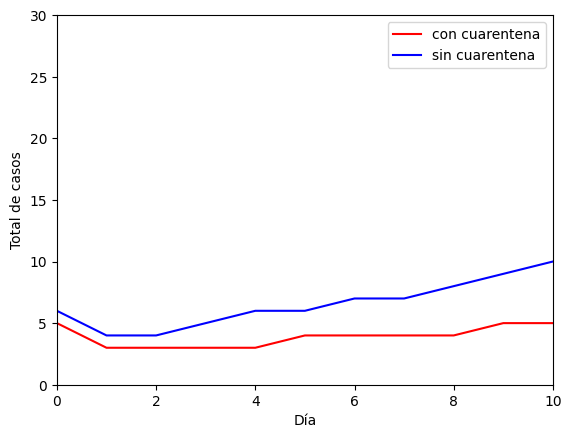

In [124]:
sns.lineplot(data = df_1, x = df_1.index, y = df_1['total cases'], color = 'red', label = f'con cuarentena')
#sns.lineplot(data = df_11, x = df_11.index, y = df_11['total_cases'], color = 'green', label = f'con cuarentena modificado')
sns.lineplot(data = df_2, x = df_2.index, y = df_2['total cases'], color = 'blue', label = f'sin cuarentena')

plt.xlabel("Día")
plt.ylabel("Total de casos")

plt.xlim((0,10))
plt.ylim((0,30))

In [ ]:
# https://towardsdatascience.com/all-you-need-to-know-to-build-your-first-llm-app-eb982c78ffac
# https://towardsdatascience.com/7-of-the-most-used-feature-engineering-techniques-bcc50f48474d
# https://towardsdatascience.com/130-ml-tricks-and-resources-curated-carefully-from-3-years-plus-free-ebook-7832ca4a37ef

In [128]:
my_test_cfg = '/content/drive/MyDrive/Malaria/PatchSim_files/cfg_paramfile_RM.txt'
cfg_test_dict = read_config(my_test_cfg)
patches_test = load_patch(cfg_test_dict)

INFO:__main__:Loaded patch attributes


In [ ]:
my_test_cfg = '/content/drive/MyDrive/Malaria/PatchSim_files//US_simulation_RM/cfg_paramfile_US_RM.txt'

data_test = pd.read_csv('/content/drive/MyDrive/Malaria/PatchSim_files/quarantines.csv', sep = ' ')
data_test = data_test[['month','week','workplaces_percent_change_from_baseline']]
data_test = data_test.groupby(['week'], as_index = False)['workplaces_percent_change_from_baseline'].mean()
data_test['workplaces_percent_change_from_baseline'] = data_test['workplaces_percent_change_from_baseline'].apply(lambda item: (item + 100)/100)
data_test['week'] = data_test['week'] - 1
df_tail = pd.DataFrame(data = {'week':[47,48,49,50,51,52], 'workplaces_percent_change_from_baseline':[0.65,0.68,0.72,0.78, 0.85,0.9]}, index = [47,48,49,50,51,52])
data_test = pd.concat([data_test, df_tail])
data_test.loc[0:5, 'workplaces_percent_change_from_baseline'] = 0.9
data_test['workplaces_percent_change_from_baseline'] = data_test['workplaces_percent_change_from_baseline'] * 0.23
cfg_test_dict = read_config(my_test_cfg)
patches_test = load_patch(cfg_test_dict)

t_test, t_test_df = load_Theta(cfg_test_dict, patches_test, there_is_quarantine=True, quarantine_rate_df=data_test, quarantine_rate_column = 'workplaces_percent_change_from_baseline')
t_test_2, t_test_df2 = load_Theta(cfg_test_dict, patches_test)

test_df1 = run_disease_simulation(cfg_test_dict, there_is_quarantine=True,Theta=t_test, return_epi=True)
test_df2 = run_disease_simulation(cfg_test_dict, Theta=t_test_2, return_epi=True)

test_results_df_1 = test_df1.T
test_results_df_2 = test_df2.T

test_results_df_1['total cases'] = test_results_df_1.sum(axis = 1)
test_results_df_2['total cases'] = test_results_df_2.sum(axis = 1)


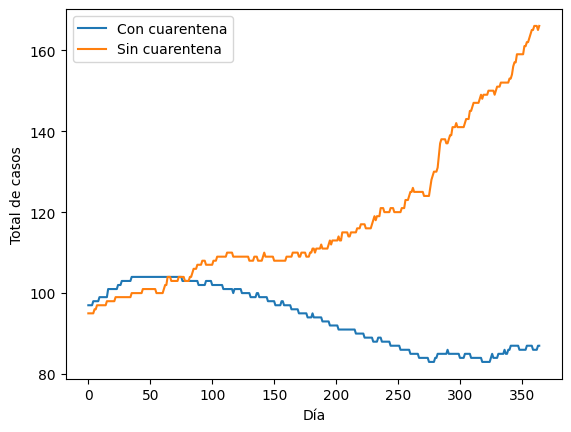

In [130]:
test_results_df_1['total cases'].plot(label = "Con cuarentena")
test_results_df_2['total cases'].plot(label = 'Sin cuarentena')
plt.xlabel("Día")
plt.ylabel("Total de casos")
plt.legend()

In [ ]:
# df.to_csv('/content/drive/MyDrive/Malaria/PatchSim_files/simulation_test/test_travel_matrix.txt', sep = ' ', index = False, columns = None)